# Annual Cycle Departures Plots Notebook

This notebook compares the annual cycle departures outputs of the CDAT, xarray, and XCDAT with plots. The goal is to ensure that their are no significant absolute differences between the plots.

## How to Use This Notebook

1. Create and activate the conda development environment
   - `conda env create -f conda-env/test_dev.yml`
   - `conda activate xcdat_test_dev`
2. Clone the `xcdat` repo
   - `git clone https://github.com/XCDAT/xcdat`
3. Install the `feature/47-climatology` branch build of `xcdat`
   - `cd xcdat`
   - `git checkout feature/47-climatology`
   - `pip install .`
4. Attach the `xcdat_test_dev` env kernel to this notebook
5. Run cells


In [1]:
# flake8: noqa F401
from typing import Dict, Literal, Tuple


import cdms2
import cdutil
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import xcdat  # noqa: F401

MONTH_STR_TO_INT = {
    "JAN": 1,
    "FEB": 2,
    "MAR": 3,
    "APR": 4,
    "MAY": 5,
    "JUN": 6,
    "JUL": 7,
    "AUG": 8,
    "SEP": 9,
    "OCT": 10,
    "NOV": 11,
    "DEC": 12,
}
MONTH_INT_TO_STR = dict(zip(MONTH_STR_TO_INT.values(), MONTH_STR_TO_INT.keys()))

## Get Temporal Averaging and Departures Outputs

### 1. Setup code

In [2]:
def cdat_outputs(
    file_name: str, var_name: str
) -> Tuple[Dict[str, xr.DataArray], Dict[str, xr.DataArray]]:
    """Get CDAT temporal averaging outputs.

    Outputs include "ANN" (original data), "ANN_ANO" (anomalies), and
    "ANN_CLIMO" (climatology)

    The CDAT TransientVariable outputs are convered to xarray DataArrays to
    make floating point comparison and plotting easier. This has no side-effects
    on the final validation.

    Parameters
    ----------
    file_name : str
        Name of the netCDF file.
    var_name : str
        Name of the variable.

    Returns
    -------
    Tuple[Dict[str, xr.DataArray], Dict[str, xr.DataArray]]
        Tuple of dictionaries, one for temporal averages and the other for
        spatial averages for the temporal averages.
    """
    ds = cdms2.openDataset(file_name)

    # Take first 4 years (0-48) and unit adjust (-273.15, K to C)
    t_var = ds(var_name, time=slice(0, 48)) - 273.15

    # Calculate climatology
    t_var_climo = cdutil.ANNUALCYCLE.climatology(t_var)
    d_var_climo = xr.DataArray(
        name=var_name,
        data=t_var_climo,
        coords={
            "month": np.array(range(1, 13)),
            "lat": list(t_var_climo.getLatitude()),
            "lon": list(t_var_climo.getLongitude()),
        },
        dims=["month", "lat", "lon"],
    )

    # Calculate departures
    t_var_ano = cdutil.ANNUALCYCLE.departures(t_var)
    d_var_ano = xr.DataArray(
        name=var_name,
        data=t_var_ano,
        coords={
            "time": np.array(
                t_var_ano.getTime().asComponentTime(), dtype="datetime64[s]"
            ),
            "lat": list(t_var_ano.getLatitude()),
            "lon": list(t_var_ano.getLongitude()),
        },
        dims=["time", "lat", "lon"],
    )

    # Convert to an xarray DataArray for comparison to xarray and XCDAT
    d_var = xr.DataArray(
        name=var_name,
        data=t_var,
        coords={
            "time": np.array(t_var.getTime().asComponentTime(), dtype="datetime64[s]"),
            "lat": list(t_var.getLatitude()),
            "lon": list(t_var.getLongitude()),
        },
        dims=["time", "lat", "lon"],
    )

    # Calculate spatial averages of the temporal averages
    t_var_ts = cdutil.averager(t_var, axis="xy")
    t_var_climo_ts = cdutil.averager(t_var_climo, axis="xy")
    t_var_ano_ts = cdutil.averager(t_var_ano, axis="xy")

    # Add temporal averaging and spatial averaging outputs to dictionaries
    temp_avg_outputs = {
        "ANN": d_var,
        "ANN_ANO": d_var_ano,
        "ANN_CLIMO": d_var_climo,
    }
    spatial_avg_outputs = {
        "ANN": xr.DataArray(
            name=var_name,
            data=t_var_ts,
            coords={
                "time": np.array(
                    t_var_ts.getTime().asComponentTime(), dtype="datetime64[s]"
                )
            },
            dims=["time"],
        ),
        "ANN_ANO": xr.DataArray(
            name=var_name,
            data=t_var_ano_ts,
            coords={
                "time": np.array(
                    t_var_ano_ts.getTime().asComponentTime(), dtype="datetime64[s]"
                )
            },
            dims=["time"],
        ),
        "ANN_CLIMO": xr.DataArray(
            name=var_name,
            data=t_var_climo_ts,
            coords={"month": np.arange(1, 13)},
            dims=["month"],
        ),
    }

    return temp_avg_outputs, spatial_avg_outputs


def global_area_averager(data_var: xr.DataArray, weighted=True) -> xr.DataArray:
    """Calculate the global area average for a data variable.

    The data variable must include lat and lon dimensions.

    Parameters
    ----------
    data_var : xr.DataArray
        The data variable.

    Returns
    -------
    xr.DataArray
    """
    with xr.set_options(keep_attrs=True):
        if weighted:
            weights = np.cos(np.deg2rad(data_var.lat))
            weights.name = "weights"
            dv_weighted = data_var.weighted(weights)
            dv_mean = dv_weighted.mean(("lon", "lat"))
            return dv_mean
        else:
            dv_mean = data_var.mean(("lon", "lat"))
    return dv_mean


def xr_outputs(
    file_name: str, data_var: str
) -> Tuple[Dict[str, xr.DataArray], Dict[str, xr.DataArray]]:
    """Get xarray temporal averaging outputs.

    Outputs include "ANN" (original data), "ANN_ANO" (anomalies), and
    "ANN_CLIMO" (climatology)

    Parameters
    ----------
    file_name : str
        Name of the netCDF file.
    var_name : str
        Name of the variable.

    Returns
    -------
    Tuple[Dict[str, xr.DataArray], Dict[str, xr.DataArray]]
        Tuple of dictionaries, one for temporal averages and the other for
        spatial averages for the temporal averages.
    """
    def annual_cycle_climatology(d, weighted=True):
        with xr.set_options(keep_attrs=True):
            if weighted:
                # Make a DataArray with the number of days in each month, size = len(time)
                month_length = d.time.dt.days_in_month

                # Calculate the weights by grouping by 'time.month'
                weights = (
                    month_length.groupby("time.month")
                    / month_length.groupby("time.month").sum()
                )

                # Test that the sum of the weights for each season is 1.0
                np.testing.assert_allclose(
                    weights.groupby("time.month").sum().values, np.ones(12)
                )

                # Calculate the weighted average
                return (d * weights).groupby("time.month").sum(dim="time")
            else:
                return d.groupby("time.month").mean("time")

    def annual_cycle_departures(dv, dv_annual_climo):
        with xr.set_options(keep_attrs=True):
            d_ann_ano = dv.groupby("time.month") - dv_annual_climo
            d_ann_ano.name = dv.name
        return d_ann_ano

    ds = xr.open_dataset(file_name)

    # Take first 4 years (0-48) and adjust temperature units (-273.15, K to C)
    dv = ds[data_var][0:48] - 273.15

    # Calculate climatology and departures
    dv_climo = annual_cycle_climatology(dv)
    dv_anomalies = annual_cycle_departures(dv, dv_climo)

    # Add temporal averaging and spatial averaging outputs to dictionaries
    xr_temp_out = {
        "ANN": dv,
        "ANN_ANO": dv_anomalies,
        "ANN_CLIMO": dv_climo,
    }
    xr_spat_out = {
        "ANN": global_area_averager(dv),
        "ANN_ANO": global_area_averager(dv_anomalies),
        "ANN_CLIMO": global_area_averager(dv_climo),
    }

    return xr_temp_out, xr_spat_out


def xcdat_outputs(
    file: str, data_var: str
) -> Tuple[Dict[str, xr.DataArray], Dict[str, xr.DataArray]]:
    """Get XCDAT temporal averaging outputs.

    Outputs include "ANN" (original data), "ANN_ANO" (anomalies), and
    "ANN_CLIMO" (climatology)

    Parameters
    ----------
    file_name : str
        Name of the netCDF file.
    var_name : str
        Name of the variable.

    Returns
    -------
    Tuple[Dict[str, xr.DataArray], Dict[str, xr.DataArray]]
        Tuple of dictionaries, one for temporal averages and the other for
        spatial averages for the temporal averages.
    """
    ds = xcdat.open_dataset(file)

    # Take first 4 years (0-48)
    ds = ds.isel(time=slice(0, 48))
    # Adjust temperature units (-273.15, K to C)
    ds[data_var] = ds[data_var] - 273.15

    # Calculate climatology and departures
    ds_climo = ds.temporal.temporal_avg(
        data_var,
        "climatology",
        "month",
        weighted=True,
        center_times=True,
        season_config={"dec_mode": "DJF", "drop_incomplete_djf": False},
    )
    ds_anomalies = ds_climo.temporal.departures(data_var)

    # Add temporal averaging and spatial averaging outputs to dictionaries
    temp_avg_outputs = {
        "ANN": ds[data_var],
        "ANN_ANO": ds_anomalies[data_var],
        "ANN_CLIMO": ds_climo[data_var],
    }
    spat_avg_outputs = {
        "ANN": global_area_averager(ds[data_var]),
        "ANN_ANO": global_area_averager(ds_anomalies[data_var]),
        "ANN_CLIMO": global_area_averager(ds_climo[data_var]),
    }

    return temp_avg_outputs, spat_avg_outputs

### 2. Run functions and store dictionary outputs

In [3]:
vars_to_files = {
    "ts": "./input/demo_data/CMIP5_demo_data/ts_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc",
    "psl": "./input/demo_data/CMIP5_demo_data/psl_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc",
    "TS": "/p/user_pub/work/E3SM/1_0/historical/1deg_atm_60-30km_ocean/atmos/180x360/time-series/mon/ens1/v5/TS_185001_201412.nc"
}

# Change var name to plot different files (UNTESTED)
var_name = "ts"
file_name = vars_to_files[var_name]

# Generate outputs
cdat_temp_out, cdat_spat_out = cdat_outputs(file_name, var_name)
xr_temp_out, xr_spat_out = xr_outputs(file_name, var_name)
xcdat_temp_out, xcdat_spat_out = xcdat_outputs(file_name, var_name)

## Plot the dictionary outputs

### Plots 1 
Original Data ("ANN") and Anomalies ("ANN_ANO") with their Global Spatial Averages by Library

In [4]:
def plot_outputs(
    library_name: str,
    temp_avg_outputs: Dict[str, xr.DataArray],
    spat_avg_outputs: Dict[str, xr.DataArray],
):
    """Plots the temporal and spatial averaging outputs for a Python library.

    Parameters
    ----------
    library_name : str
        The name of the library
    temporal_out : Dict[str, xr.DataArray]
        The temporal averaging outputs.
    spatial_out : Dict[str, xr.DataArray]
        The spatial averaging outputs.
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle(library_name, fontsize=16)

    for i, (data_type, data) in enumerate(temp_avg_outputs.items()):
        if data_type == "ANN":
            cmap = "Spectral_r"
            vmin = -30
            vmax = 30
        elif data_type == "ANN_ANO":
            cmap = "RdBu_r"
            vmin = -5
            vmax = 5
        else:
            continue

        notnull = pd.notnull(data[0])
        data[0].where(notnull).plot.pcolormesh(
            ax=axes[i, 0],
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            add_colorbar=True,
            extend="both",
        )
        axes[i, 0].set_title(data_type + " (t=0)")
        axes[i, 0].set_xticklabels([])
        axes[i, 0].set_yticklabels([])
        axes[i, 0].set_xlabel("")
        axes[i, 0].set_ylabel("")

        # Time series
        axes[i, 1].set_title(data_type + ", Global Avg")
        if data_type in ["ANN", "ANN_ANO"]:
            dates = spat_avg_outputs[data_type].time.values
            x = dates
            axes[i, 1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        elif data_type in ["ANN_CLM"]:
            x = list(range(1, 13))

        axes[i, 1].plot(x, spat_avg_outputs[data_type])

    plt.tight_layout()

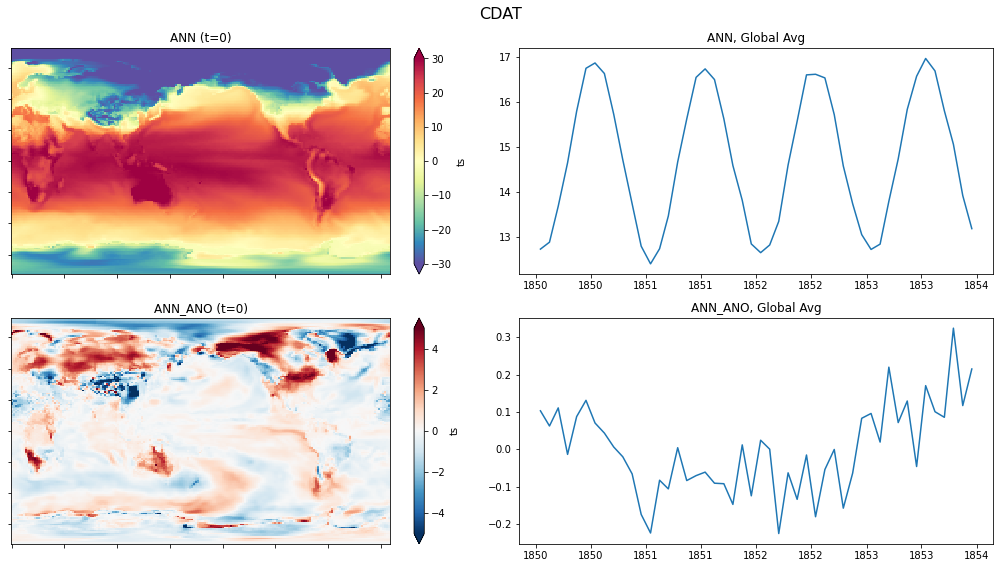

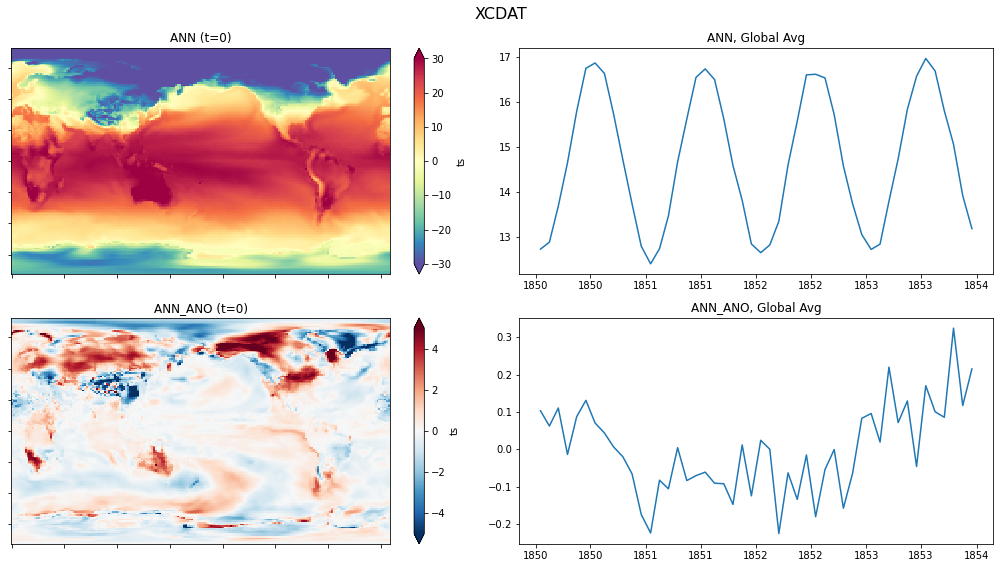

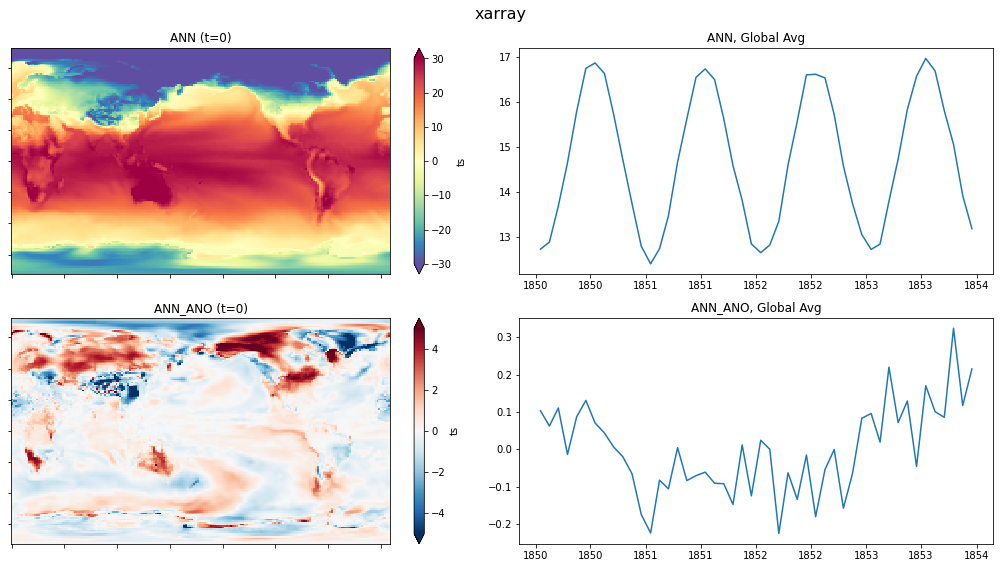

In [5]:
plot_outputs("CDAT", cdat_temp_out, cdat_spat_out)
plot_outputs("XCDAT", xcdat_temp_out, xcdat_spat_out)
plot_outputs("xarray", xr_temp_out, xr_spat_out)

### Plots 2
Climatologies by month with the absolute and relative differences between libraries.

In [6]:
def compare_climos_by_month(
    lib_a_name: str,
    lib_a_output: xr.DataArray,
    lib_b_name: str,
    lib_b_output: xr.DataArray,
    diff_type: Literal["abs", "rel"],
):
    """Plots and compares the climatology outputs between two libraries.

    Parameters
    ----------
    lib_a_name : str
        Name of the first library.
    lib_a_output : xr.DataArray
        Temporal averaging outputs of the first library.
    lib_b_name : str
        Name of the second library.
    lib_b_output : xr.DataArray
        Temporal averaging outputs of the second library.
    diff_type : Literal["abs", "rel"]
        Plot the absolute or relative difference in the difference plot.
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(ncols=3, figsize=(14, 8))
    plt.tight_layout()
    fig.suptitle(
        "Surface Air Temperature Climatology (Global Area Average)",
        fontsize=16,
        y=1.05,
    )

    # Add subplots for both library outputs
    lib_a_output.plot(ax=axes[0])
    lib_b_output.plot(ax=axes[1])

    axes[0].set_title(lib_a_name)
    axes[1].set_title(lib_b_name)

    # Add subplot for absolute or relative differences
    abs_diff = abs(lib_b_output) - abs(lib_a_output)
    if diff_type == "abs":
        abs_diff.plot(ax=axes[2])
        axes[2].set_title("Absolute Difference (Decimals)")
    elif diff_type == "rel":
        rel_diff = (
            np.divide(
                abs_diff,
                abs(lib_a_output),
                out=np.zeros_like(abs_diff),
                where=lib_a_output != 0,
            )
            * 100
        )
        rel_diff.plot(ax=axes[2])  # type: ignore
        axes[2].set_title("Relative Difference (%)")

    for ax in axes.flat:
        ax.axes.axis("tight")

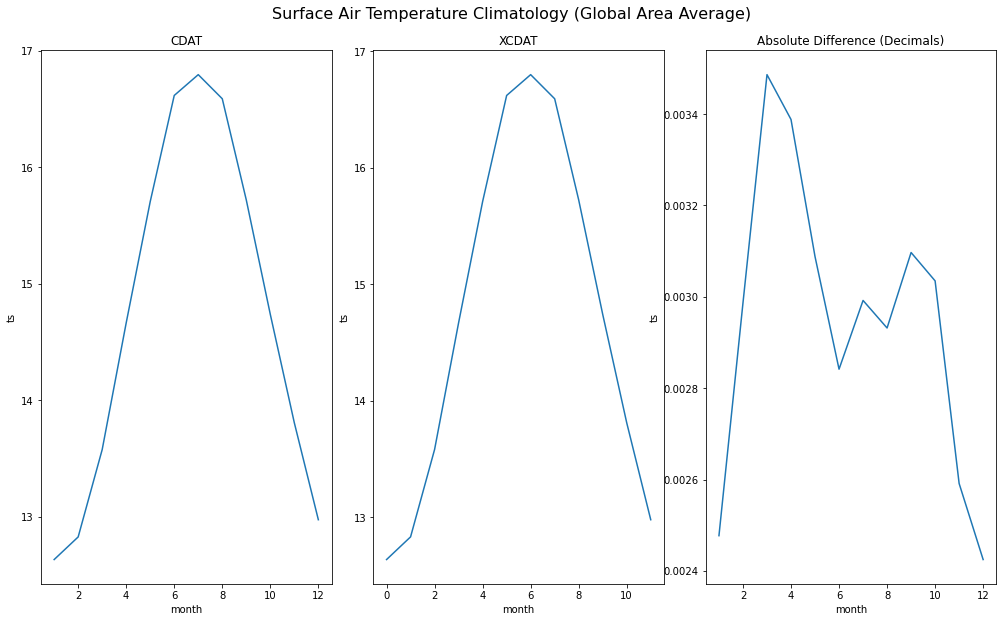

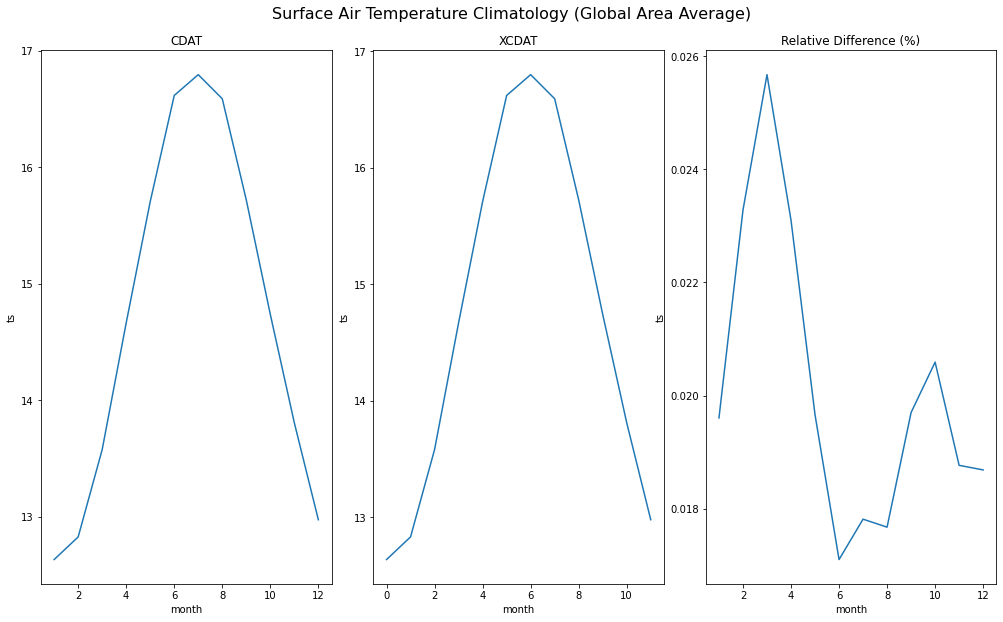

In [7]:
compare_climos_by_month(
    "CDAT",
    cdat_spat_out["ANN_CLIMO"],
    "XCDAT",
    xcdat_spat_out["ANN_CLIMO"].reset_index("month"),
    "abs",
)

compare_climos_by_month(
    "CDAT",
    cdat_spat_out["ANN_CLIMO"],
    "XCDAT",
    xcdat_spat_out["ANN_CLIMO"].reset_index("month"),
    "rel",
)

### Plot 3
Original data ("ANN"), annual cycle departures ("ANN_ANO"), the absolute differences between both libraries

In [8]:
def compare_anomalies(
    lib_a_name: str,
    lib_a_outputs: Dict[str, xr.DataArray],
    lib_b_name: str,
    lib_b_outputs: Dict[str, xr.DataArray],
    time_step: int = 1
):
    """Plots and compares the anomaly outputs between two libraries.

    Parameters
    ----------
    lib_a_name : str
        Name of the first library.
    lib_a_output : xr.DataArray
        Temporal averaging outputs of the first library.
    lib_b_name : str
        Name of the second library.
    lib_b_output : xr.DataArray
        Temporal averaging outputs of the second library.
    time_step : int
        The time step to use for plotting.
    """
    # Plot setup
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))
    plt.tight_layout()
    fig.suptitle(
        "Surface Air Temperature at t=" + str(time_step) + ", first Feb.",
        fontsize=16,
        y=1.05,
    )

    for i, (output_type, output_a) in enumerate(lib_a_outputs.items()):
        if output_type == "ANN":
            cmap = "Spectral_r"
            vmin = -30
            vmax = 30
        elif output_type == "ANN_ANO":
            cmap = "RdBu_r"
            vmin = -5
            vmax = 5
        else:
            continue

        notnull = pd.notnull(output_a[0])

        # Plot library a and library b
        output_a[time_step].where(notnull).plot.pcolormesh(
            ax=axes[i, 0],
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            add_colorbar=True,
            extend="both",
        )

        output_b = lib_b_outputs[output_type]
        output_b[time_step].where(notnull).plot.pcolormesh(
            ax=axes[i, 1],
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            add_colorbar=True,
            extend="both",
        )

        # Difference
        abs_diff = abs(output_b[time_step]) - abs(output_a[time_step])
        abs_diff = abs_diff.where(notnull).plot.pcolormesh(
            ax=axes[i, 2],
            vmin=-0.1,
            vmax=0.1,
            cmap="RdBu_r",
            add_colorbar=True,
            extend="both",
        )

    for ax in axes.flat:
        ax.axes.get_xaxis().set_ticklabels([])
        ax.axes.get_yaxis().set_ticklabels([])
        ax.axes.axis("tight")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")

    axes[0, 0].set_title(lib_a_name)
    axes[0, 1].set_title(lib_b_name)
    axes[0, 2].set_title("Difference")

    axes[0, 0].set_ylabel("ANN")
    axes[1, 0].set_ylabel("ANN_ANO")

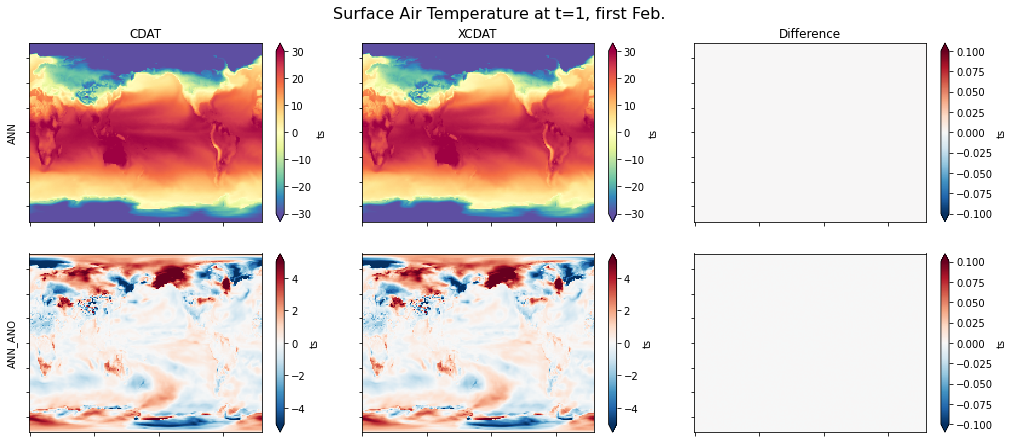

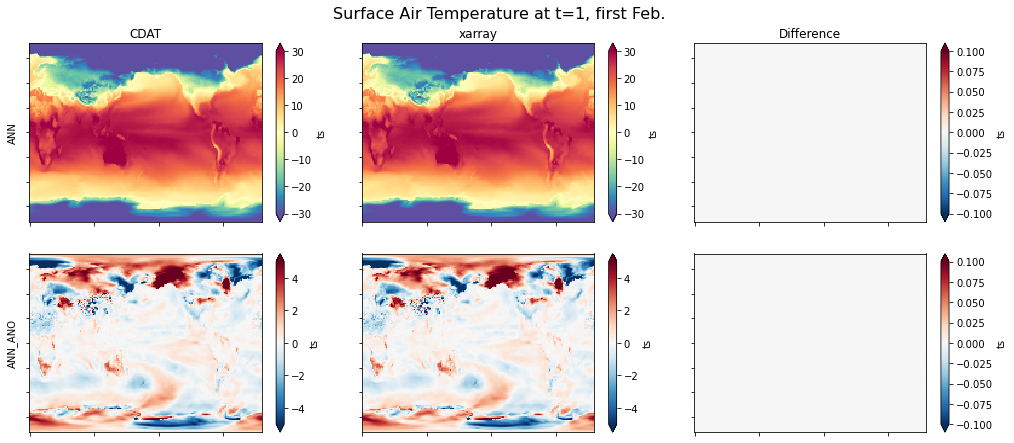

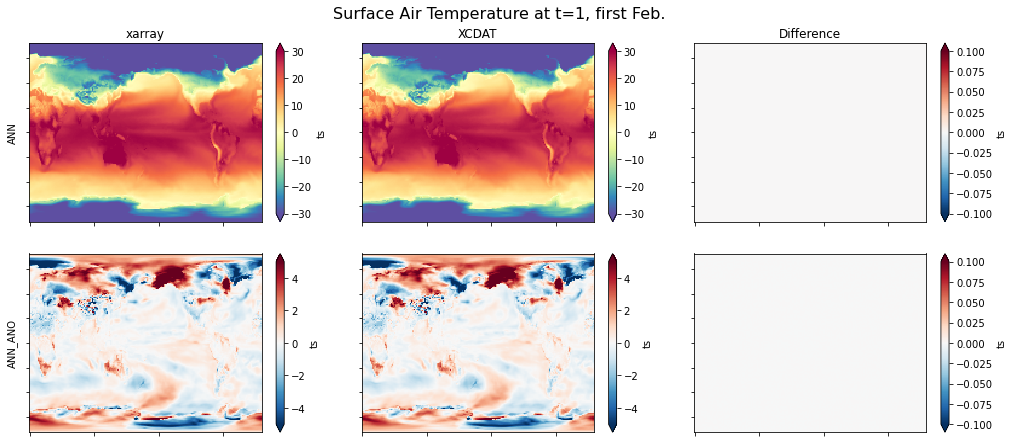

In [9]:
compare_anomalies("CDAT", cdat_temp_out, "XCDAT", xcdat_temp_out)
compare_anomalies("CDAT", cdat_temp_out, "xarray", xr_temp_out)
compare_anomalies("xarray", xr_temp_out, "XCDAT", xcdat_temp_out)

### Plot 4
Original data ("ANN"), annual cycle departures ("ANN_ANO"), the absolute differences between both libraries
by month.

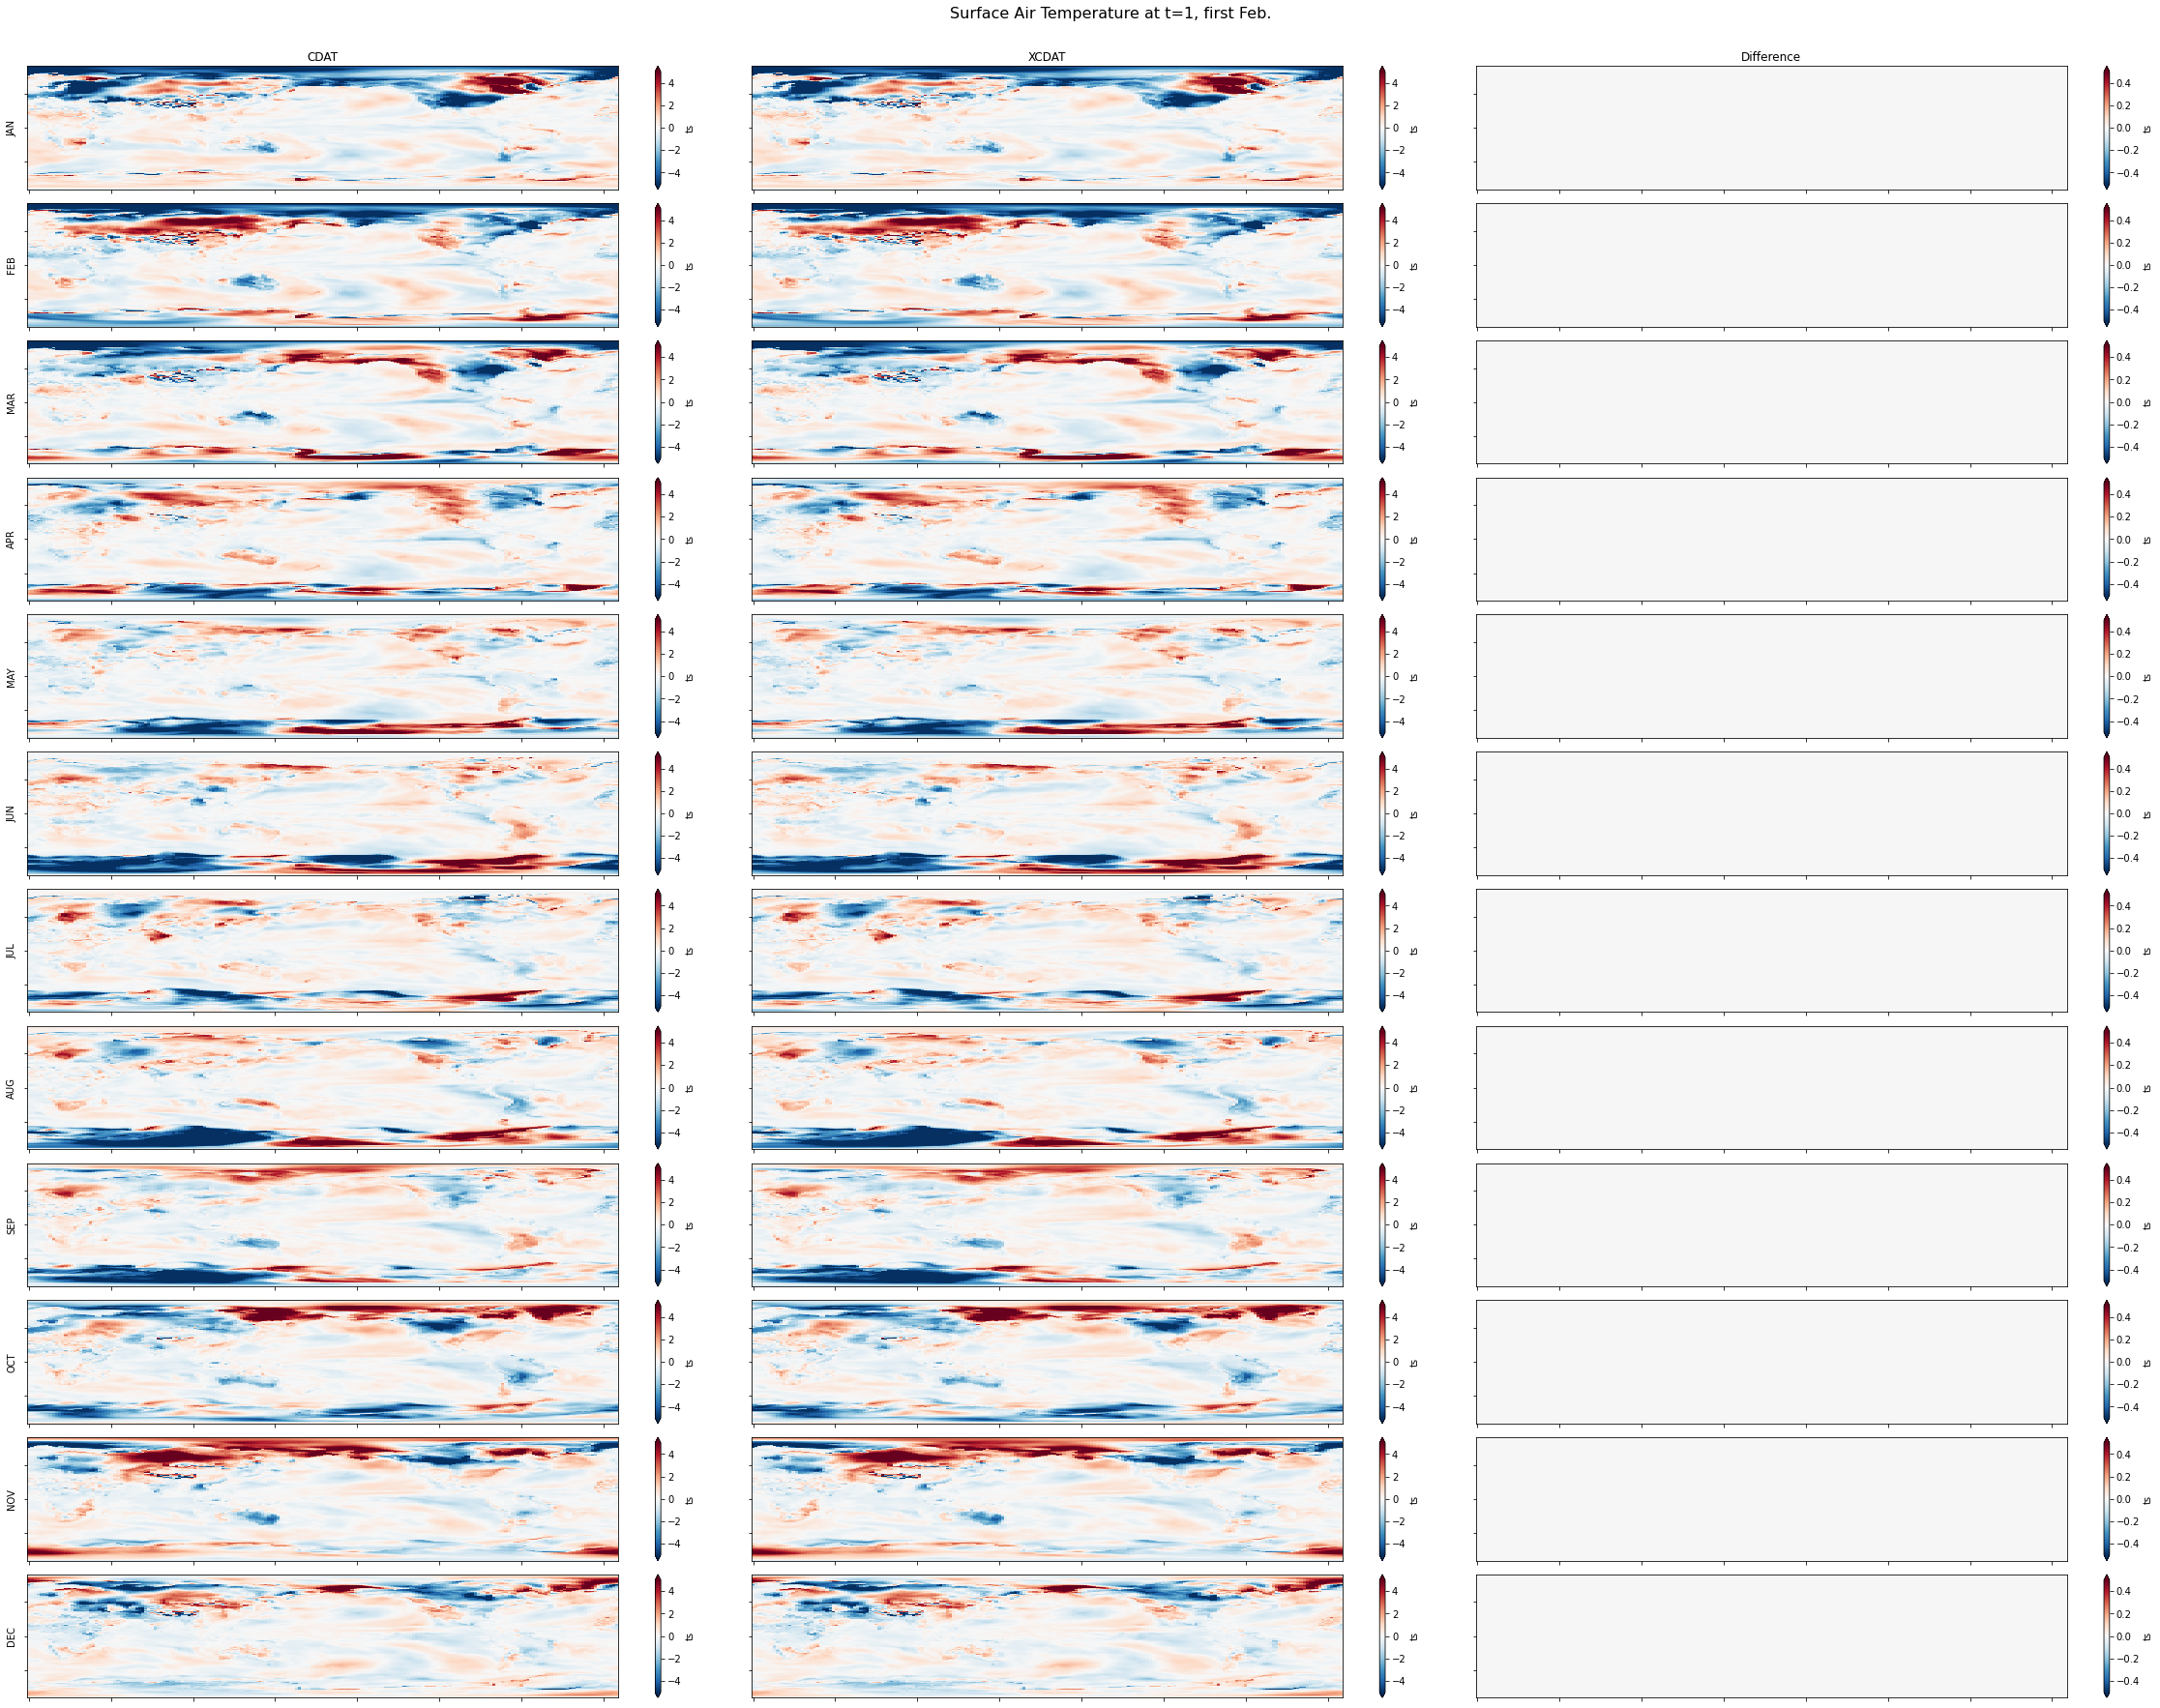

In [10]:
def compare_anomalies_by_month(
    lib_a_name: str,
    lib_a_departures: xr.DataArray,
    lib_b_name: str,
    lib_b_departures: xr.DataArray,
    time_step: int = 1
):
    """Plots and compares the anomaly outputs between two libraries by month.

    Parameters
    ----------
    lib_a_name : str
        Name of the first library.
    lib_a_departures : xr.DataArray
        Departures outputs of the first library.
    lib_b_name : str
        Name of the second library.
    lib_b_departures : xr.DataArray
        Departure outputs of the second library.
    time_step : int
        The time step to use for plotting.
    """
    # TODO: Set time step as max rel diff time step

    # Quick plot to show the results
    notnull = pd.notnull(lib_a_departures[0])

    fig, axes = plt.subplots(nrows=12, ncols=3, figsize=(32, 24))
    for i, month in enumerate(np.arange(1, 13)):
        lib_a_out_mon = lib_a_departures.sel(time=(lib_a_departures.time.dt.month) == month)
        lib_b_out_mon = lib_a_departures.sel(time=(lib_b_departures.time.dt.month) == month)

        # Plot library a and library b
        lib_a_out_mon.where(notnull)[time_step].plot.pcolormesh(
            ax=axes[i, 0],
            vmin=-5,
            vmax=5,
            cmap="RdBu_r",
            add_colorbar=True,
            extend="both",
        )

        lib_b_out_mon.where(notnull)[time_step].plot.pcolormesh(
            ax=axes[i, 1],
            vmin=-5,
            vmax=5,
            cmap="RdBu_r",
            add_colorbar=True,
            extend="both",
        )

        # Plot the absolute difference
        abs_diff = abs(lib_b_out_mon) - abs(lib_a_out_mon)
        abs_diff.sel(time=(abs_diff.time.dt.month) == month).where(notnull)[
            time_step
        ].plot.pcolormesh(
            ax=axes[i, 2],
            vmin=-0.5,
            vmax=0.5,
            cmap="RdBu_r",
            add_colorbar=True,
            extend="both",
        )

        axes[i, 0].set_ylabel(MONTH_INT_TO_STR[month])
        axes[i, 1].set_ylabel("")
        axes[i, 2].set_ylabel("")

        axes[i, 0].set_title("")
        axes[i, 1].set_title("")
        axes[i, 2].set_title("")

    for ax in axes.flat:
        ax.axes.get_xaxis().set_ticklabels([])
        ax.axes.get_yaxis().set_ticklabels([])
        ax.axes.axis("tight")
        ax.set_xlabel("")

    axes[0, 0].set_title(lib_a_name)
    axes[0, 1].set_title(lib_b_name)
    axes[0, 2].set_title("Difference")

    plt.tight_layout()

    fig.suptitle(
        "Surface Air Temperature at t=" + str(time_step) + ", first Feb.",
        fontsize=16,
        y=1.02,
    )


compare_anomalies_by_month(
    "CDAT",
    cdat_temp_out["ANN_ANO"],
    "XCDAT",
    xcdat_temp_out["ANN_ANO"],
)